In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from time import time

/content/drive/MyDrive/datagroup_projects


In [6]:
from Dataset import train_dataset, test_dataset
from Dataloader import data_loader
from Model import MNIST_Classifier
from trainer import train

In [7]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
mytransforms = transforms.Compose([
                                   transforms.Resize((50, 50)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(0.5,0.5)
])

In [9]:
# Dataset
train_data = train_dataset(mytransforms)
test_data  = test_dataset(mytransforms)

# Dataloader
train_loader = data_loader(train_data)
test_loader = data_loader(test_data)

In [10]:
# Defining Model
mymodel = MNIST_Classifier()

In [11]:
# Testing Model
test_input = torch.rand(1,1,50,50)
mymodel.flatten(test_input).shape
mymodel.forward(test_input)

tensor([[-0.0199,  0.0383,  0.0011, -0.0926,  0.0563, -0.0740,  0.0326,  0.0150,
         -0.0280,  0.0191]], grad_fn=<AddmmBackward0>)

In [12]:
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(mymodel.parameters())

mymodel = train(model = mymodel, 
      epochs = 2 ,
      train_loader = train_loader ,
      test_loader = test_loader,  
      opt = opt,  
      criterion = criterion , 
      train_data = train_data, 
      test_data = test_data)

Epoch 0, loss :  0.21676, accuracy :  0.93533,  val_loss :  0.10251, val_accuracy :  0.96750, time :  252.2
Epoch 1, loss :  0.06974, accuracy :  0.97940,  val_loss :  0.07293, val_accuracy :  0.97790, time :  252.9


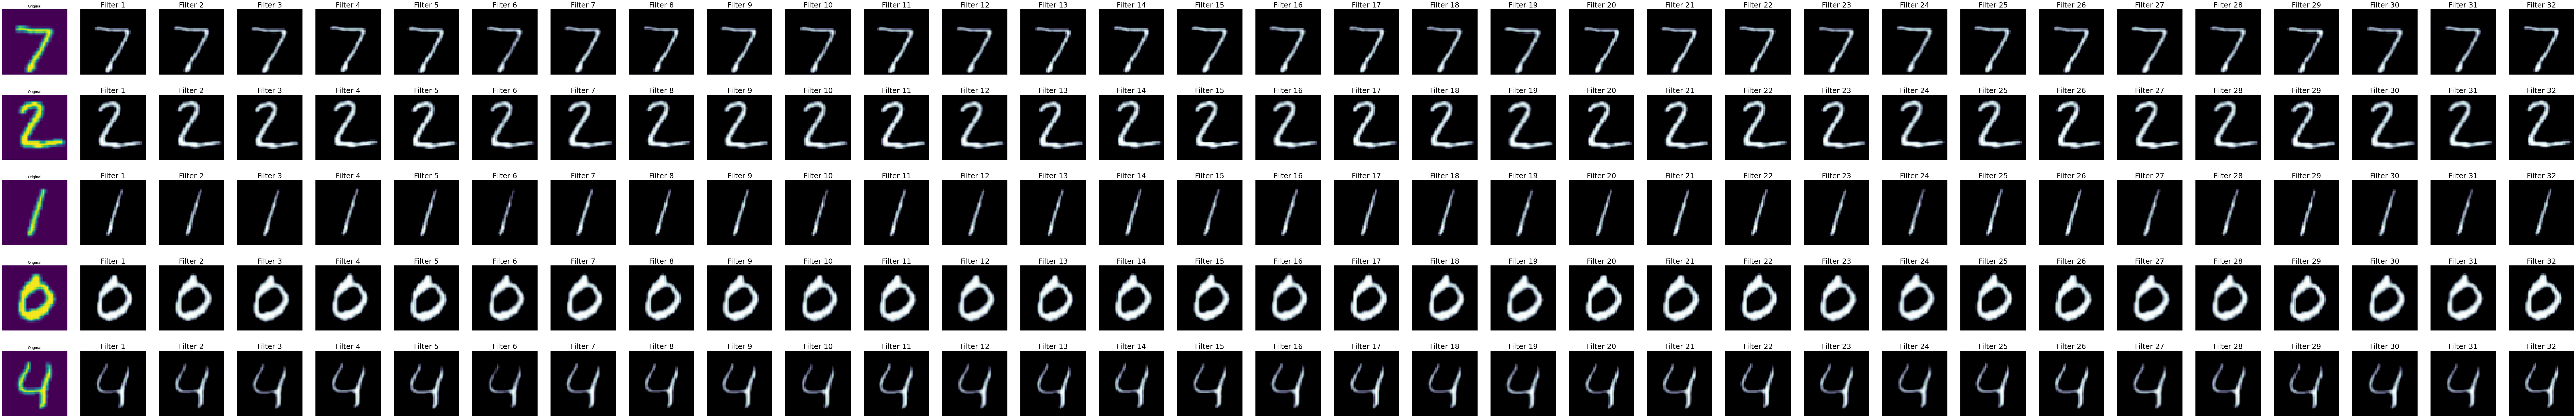

In [14]:
from typing import List
import torch.nn.functional as F




def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image


batch = next(iter(test_loader))
n_images = 5
n_filters = 32
layer_num = 1
plot_feature_map = False


images = batch[0][:n_images, ...].to(device)


model_children = list(mymodel.children())
num_layer = 2
outputs = nn.Sequential(*model_children[:num_layer])(images)

layers = []
for name,module in mymodel.named_modules():
  layers.append((name, module))


fig = plt.figure(figsize=(n_filters*5, (n_images + 3)*5))

for i in range(n_images):

    image = images[i]

    image = normalize_image(image)

    ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters) )
    ax.imshow(image.permute(1, 2, 0).cpu().numpy()[:,:,0])
    ax.set_title('Original')
    ax.axis('off')

    for j in range(n_filters):
      
      if (plot_feature_map):
        image = layers[layer_num][1].weight.data[j][0]

      else:
        image = outputs[i][j]


      image = normalize_image(image)
      ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
      ax.imshow(image.detach().cpu().numpy(), cmap = 'bone')
      ax.set_title(f'Filter {j+1}' , fontsize=25)
      ax.axis('off');

fig.subplots_adjust(hspace = -0.7)

In [ ]:
torch.save(mymodel.state_dict(), f'/content/My_Model_{epochs}.pt')